# To html
python -m nbconvert --to html research.ipynb

# Load price data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

path = "C:/Users/itataurov.KORECAPITAL/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet"

df = pd.read_parquet(path)
df.rename(columns={'datetime':'timestamp'}, inplace=True)
df = df.sort_values(by=['timestamp'])

df.head()

,symbol,timestamp,open,high,low,close,volume,mkt_cap,fundingRate,oi,...,buy_trades_perp,total_trades_perp,spot_close,buy_volume_spot,total_volume_spot,buy_trades_spot,total_trades_spot,predicted_funding_rate,short_liquidation_volume,long_liquidation_volume
0,BTC,2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291,1.862977e+11,NaN,NaN,...,NaN,NaN,10381.18,10583.392061,23977.212617,99471.0,208843.0,NaN,NaN,NaN
1,BTC,2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373,1.854112e+11,NaN,NaN,...,NaN,NaN,10303.12,18729.472684,39835.727608,141490.0,289009.0,NaN,NaN,NaN
2,BTC,2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955,1.824183e+11,0.0003,NaN,...,NaN,NaN,10098.15,13430.583727,28911.844232,122732.0,251048.0,NaN,NaN,NaN
3,BTC,2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922,1.830630e+11,0.0003,NaN,...,NaN,NaN,10158.33,16580.247908,31946.418957,145852.0,270589.0,NaN,NaN,NaN
4,BTC,2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634,1.864050e+11,0.0003,NaN,...,4748.0,9848.0,10415.01,18529.736860,34461.558090,142940.0,271187.0,NaN,NaN,NaN


# Universe growth

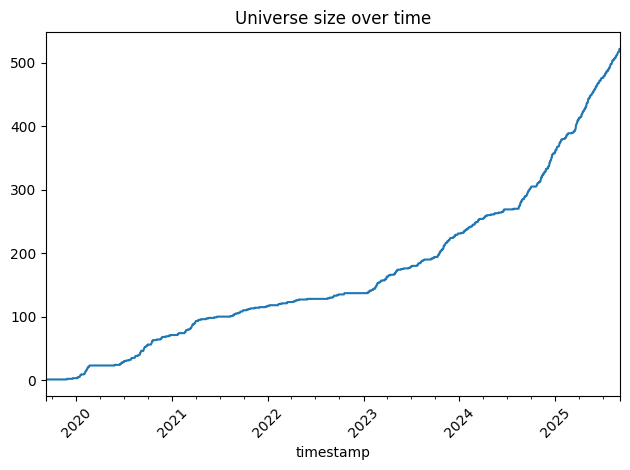

In [2]:
# plot universe size over time
df.groupby('timestamp').size().plot()
plt.title("Universe size over time")
plt.xticks(rotation=45)
plt.tight_layout()

# Forward returns

In [3]:
# Add forward returns
def add_n_day_forward_returns(df, n):
	# print(f"Adding {n} period forward returns")
	df[f"fwd_return_{n}d"] = (
		df.groupby("symbol")["close"]
		.transform(lambda x: x.shift(-n) / x - 1)
	)
	
	# Define a helper that computes the future sum using reversed rolling window
	def future_sum(series, n):
		# Reverse the series so that future values become the "past"
		rev = series.iloc[::-1]
		# Compute a rolling sum on the reversed series; use min_periods=n to only include rows with a full window
		rolled = rev.rolling(window=n, min_periods=n).sum().iloc[::-1]
		# Shift by -1 to align each row with the sum of the NEXT n periods (i.e., skip the current row)
		return rolled.shift(-1)
	
	# Apply the helper to each group and make sure to reset the index to match df
	df[f'fwd_funding_return_{n}d'] = df.groupby('symbol')['fundingRate'] \
									   .apply(lambda s: future_sum(s, n)) \
									   .reset_index(level=0, drop=True)
	# combined
	df[f'fwd_combined_return_{n}d'] = df[f'fwd_return_{n}d'] - df[f'fwd_funding_return_{n}d']
	return df

df.sort_values('timestamp', inplace=True)

for n in range(1, 61):
	df = add_n_day_forward_returns(df, n)

# copy df to de-fragment it
df = df.copy()

C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_24160\3146204996.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'fwd_funding_return_{n}d'] = df.groupby('symbol')['fundingRate'] \
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_24160\3146204996.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'fwd_combined_return_{n}d'] = df[f'fwd_return_{n}d'] - df[f'fwd_funding_return_{n}d']
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_24160\3146204996.py:4: PerformanceWarning: DataFrame 

<Axes: xlabel='timestamp'>

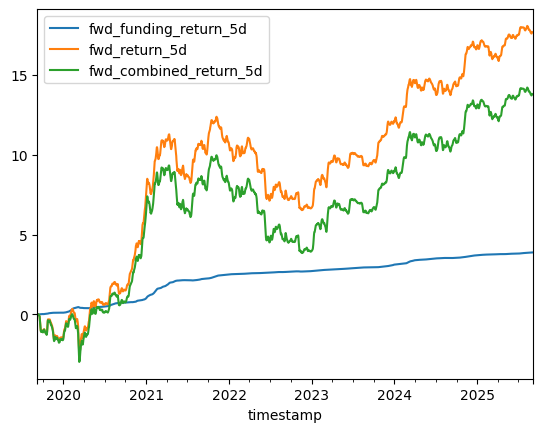

In [4]:
btc = df[df['symbol'] == 'BTC'].set_index('timestamp').sort_index()
btc[['fwd_funding_return_5d', 'fwd_return_5d', 'fwd_combined_return_5d']].cumsum().plot()

Funding rate is important to consider in modelling

In [5]:
# make vol a mix of long term(using expanding window) and short term (using ewm)
df['return'] = df.groupby('symbol')['close'].pct_change()
df['vol_expanding_window'] = (
	df.groupby('symbol')['return']
		.transform(lambda x: x
					.expanding(min_periods=30)
					.std())
)
df['vol_ewm'] = (
	df.groupby('symbol')['return']
		.transform(lambda x: x
					.ewm(span=30, adjust=False, min_periods=30)
					.std())
)
df['volatility'] = (
	df['vol_expanding_window'] * 0.25 +
	df['vol_ewm'] * 0.75
)

<Axes: xlabel='timestamp'>

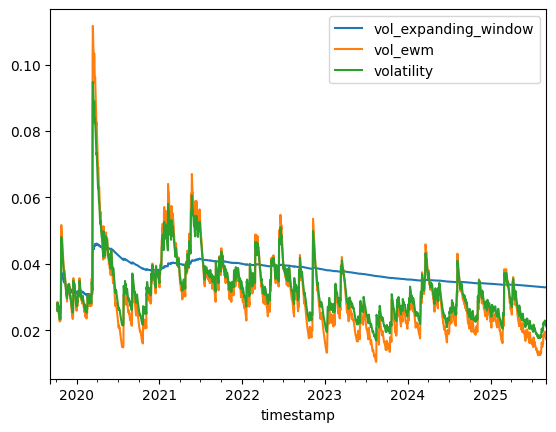

In [6]:
btc = df[df['symbol'] == 'BTC'].set_index('timestamp').sort_index()
btc[['vol_expanding_window', 'vol_ewm', 'volatility']].plot()

In [7]:
# Universe selection
df['dollar_volume'] = df['close'] * df['volume']
df['dollar_volume_slowed'] = (
	df.groupby('symbol')['dollar_volume']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
)
df['dv_rank'] = (
	df.groupby('timestamp')['dollar_volume_slowed']
		.rank(method='first', ascending=False)
		.fillna(1000000)
		.astype(int)
)
df['dv_decile'] = df.groupby('timestamp')['dollar_volume_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

df['market_cap_slowed'] = (
	df.groupby('symbol')['mkt_cap']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
)
df['mc_rank'] = (
	df.groupby('timestamp')['market_cap_slowed']
		.rank(method='first', ascending=False)
		.fillna(1000000)
		.astype(int)
)
df['mc_decile'] = df.groupby('timestamp')['market_cap_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

# days since listing
df['days_since_listing'] = df.groupby('symbol').cumcount() + 1

<Axes: xlabel='timestamp'>

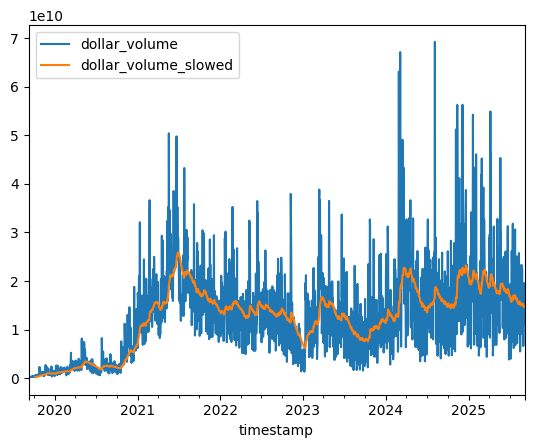

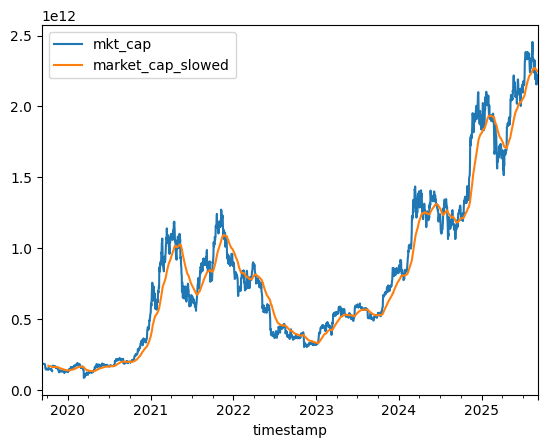

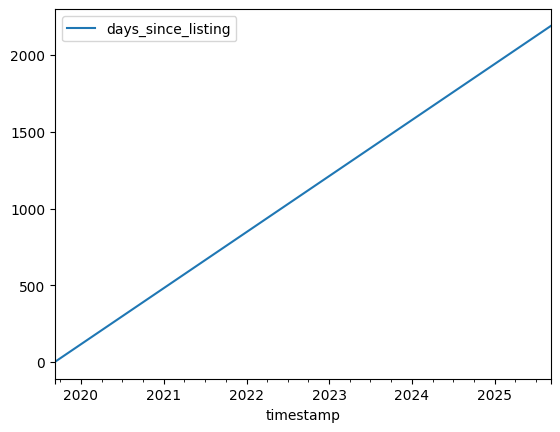

In [8]:
btc = df[df['symbol'] == 'BTC'].set_index('timestamp').sort_index()
btc[['dollar_volume', 'dollar_volume_slowed']].plot()
btc[['mkt_cap', 'market_cap_slowed']].plot()
btc[['days_since_listing']].plot()

# Compute signal

In [91]:
import signals

lookbacks = [1,2, 4, 8, 16, 32, 64, 128, 256]

for l in lookbacks:
	print(f"Computing signal for lookback {l}")
	df = signals._compute_liquidation_imbalance(df, f'signal_{l}d', l)


Computing signal for lookback 1
Computing liquidation imbalance signal...


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4673: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4673: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4673: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python31

Computing signal for lookback 2
Computing liquidation imbalance signal...


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4673: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4673: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\P

Computing signal for lookback 4
Computing liquidation imbalance signal...


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4673: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\itataurov.KORECAPITAL\App

Computing signal for lookback 8
Computing liquidation imbalance signal...


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.K

Computing signal for lookback 16
Computing liquidation imbalance signal...


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.K

Computing signal for lookback 32
Computing liquidation imbalance signal...


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.K

Computing signal for lookback 64
Computing liquidation imbalance signal...


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.K

Computing signal for lookback 128
Computing liquidation imbalance signal...


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.K

Computing signal for lookback 256
Computing liquidation imbalance signal...


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\itataurov.K

<Axes: xlabel='timestamp'>

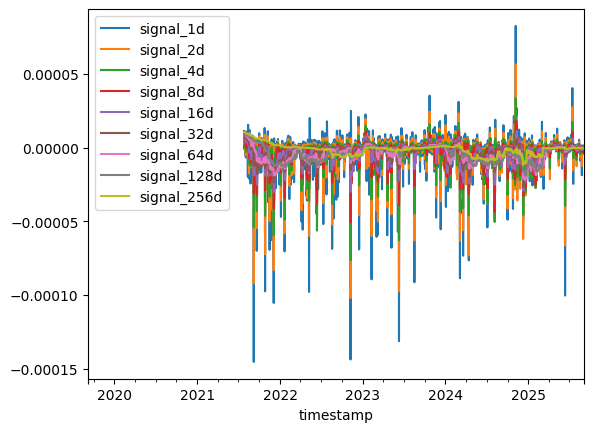

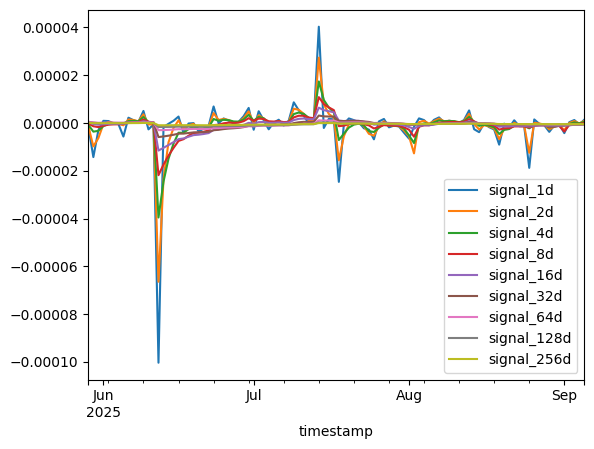

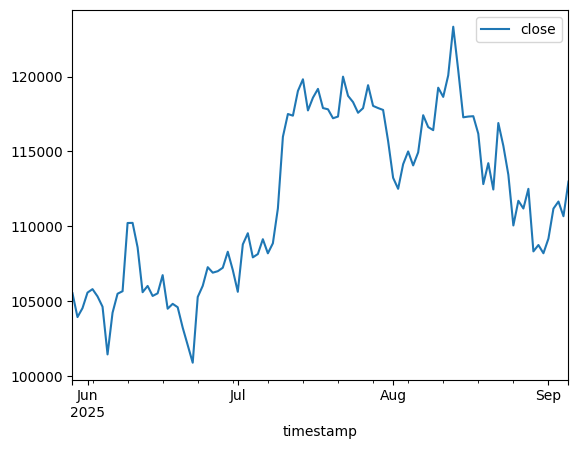

In [92]:
btc = df[df['symbol'] == 'BTC'].set_index('timestamp').sort_index()
btc[['signal_1d', 'signal_2d', 'signal_4d', 'signal_8d', 'signal_16d', 'signal_32d', 'signal_64d', 'signal_128d', 'signal_256d']].plot()
btc[['signal_1d', 'signal_2d', 'signal_4d', 'signal_8d', 'signal_16d', 'signal_32d', 'signal_64d', 'signal_128d', 'signal_256d']][-100:].plot()
btc[['close']][-100:].plot()

# Filter illiquids 

In [ ]:
# Select universe
df_filtered = df[df.dollar_volume_slowed >= 5e6] # at least $5M daily volume 
df_filtered = df_filtered[df_filtered['days_since_listing'] >= 90] # at least 90 days since listing (need data for risk estimate)
df_filtered = df_filtered[df_filtered.timestamp<'2025-01-01']
df_filtered = df_filtered[df_filtered.timestamp>'2021-01-01']
print(f"Filtered down from {len(df)} to {len(df_filtered)} rows")

Filtered down from 371753 to 218811 rows


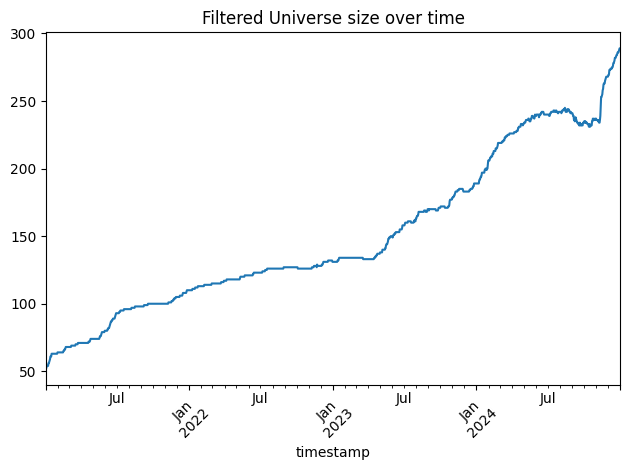

In [131]:
# plot universe size over time
df_filtered.groupby('timestamp').size().plot()
plt.title("Filtered Universe size over time")
plt.xticks(rotation=45)
plt.tight_layout()

In [132]:
# Demean forward returns cross-sectionally (by timestamp) (this is your target)
price_cols    = [f"fwd_return_{n}d"          for n in range(1, 61)]
funding_cols  = [f"fwd_funding_return_{n}d"  for n in range(1, 61)]
combined_cols = [f"fwd_combined_return_{n}d" for n in range(1, 61)]

for col in combined_cols:
    means = df_filtered.groupby("timestamp")[col].transform("mean")
    new_col = f"{col}_demeaned"
    df_filtered[new_col] = df_filtered[col] - means

df_filtered = df_filtered.copy() # de-fragment

In [133]:
df_filtered.columns[0:30]

Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'mkt_cap', 'fundingRate', 'oi', 'ls_ratio', 'longs_pct',
       'buy_volume_perp', 'total_volume_perp', 'buy_trades_perp',
       'total_trades_perp', 'spot_close', 'buy_volume_spot',
       'total_volume_spot', 'buy_trades_spot', 'total_trades_spot',
       'predicted_funding_rate', 'short_liquidation_volume',
       'long_liquidation_volume', 'fwd_return_1d', 'fwd_funding_return_1d',
       'fwd_combined_return_1d', 'fwd_return_2d', 'fwd_funding_return_2d',
       'fwd_combined_return_2d'],
      dtype='object')

# Visualize signals

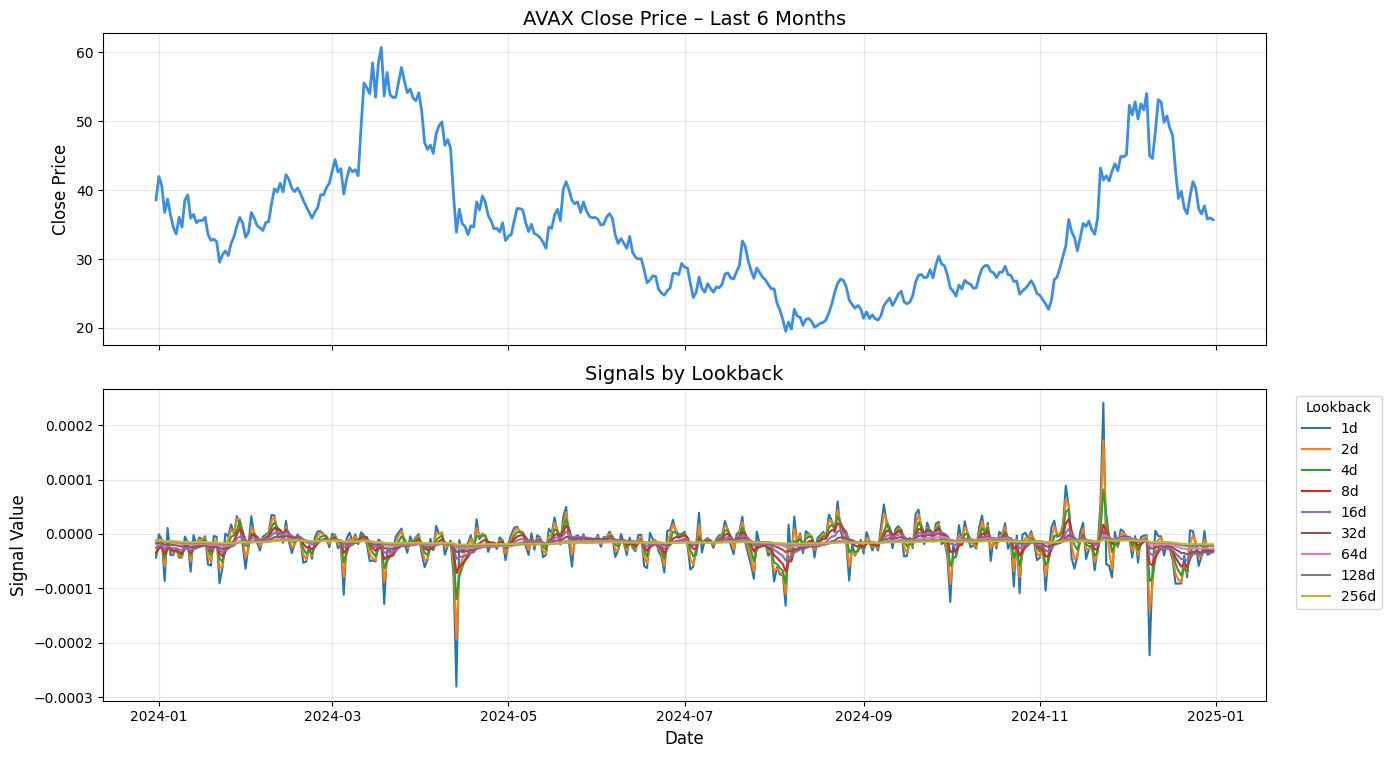

In [134]:
import matplotlib.pyplot as plt
import pandas as pd

# --- AVAX slice, last 12 months ----------------------------
btc = df_filtered[df_filtered['symbol'] == 'AVAX'].copy()
btc['timestamp'] = pd.to_datetime(btc['timestamp'])
end   = btc['timestamp'].max()
start = end - pd.DateOffset(months=12)
btc   = btc[btc['timestamp'] >= start]

# --- plot: price on top, signals bottom (equal height) ------------------
fig, (ax1, ax2) = plt.subplots(
	nrows=2,
	ncols=1,
	sharex=True,
	figsize=(14, 8),
	gridspec_kw={"height_ratios": [1, 1]}  # equal heights
)

# Top: AVAX price
ax1.plot(btc['timestamp'], btc['close'], color="#3B8EE5", lw=2)
ax1.set_ylabel('Close Price', fontsize=12)
ax1.set_title('AVAX Close Price – Last 6 Months', fontsize=14)
ax1.grid(True, alpha=0.3)

# Bottom: signals
for l in lookbacks:
	ax2.plot(
		btc['timestamp'],
		btc[f'signal_{l}d'],
		lw=1.5,
		label=f'{l}d'
	)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Signal Value', fontsize=12)
ax2.set_title('Signals by Lookback', fontsize=14)
ax2.legend(
	title='Lookback',
	bbox_to_anchor=(1.02, 1),
	loc='upper left'
)
ax2.grid(True, alpha=0.3)

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Lookback selection

### IC vs lookback

1
2
4
8
16
32
64
128
256


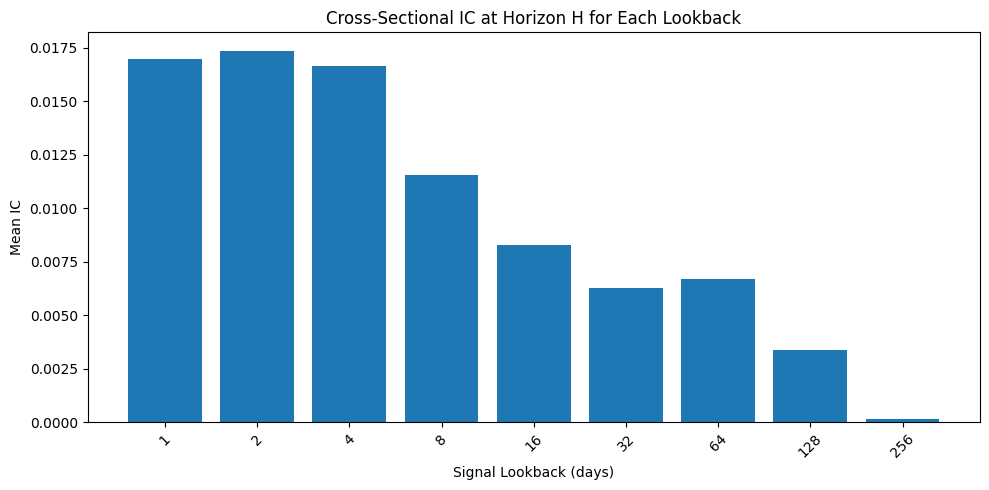

          avg_turnover  avg_hold_days  horizon_H        IC
lookback                                                  
1             0.985885       1.014317         10  0.016978
2             0.608743       1.642729         10  0.017345
4             0.375563       2.662669         10  0.016632
8             0.221855       4.507448         10  0.011551
16            0.127273       7.857137         10  0.008268
32            0.076007      13.156740         10  0.006289
64            0.049305      20.281865         10  0.006702
128           0.033433      29.910409         10  0.003354
256           0.025434      39.317804         10  0.000153


In [135]:
results = []

for l in lookbacks:
	print(l)
	sig_col = f"signal_{l}d"

	# ——— 1) build the raw signal matrix, with NaNs for missing symbols ———
	S = df_filtered.pivot(
		index="timestamp",
		columns="symbol",
		values=sig_col,
	)  # missing value -> NaN

	# ——— 2) subtract the cross‐sectional mean (skipna=True by default) ———
	S0 = S.sub(S.mean(axis=1), axis=0)

	# ——— 3) normalize by the sum of abs deviations (skipna=True) ———
	norm = S0.abs().sum(axis=1)
	W = S0.div(norm, axis=0)

	# ——— 4) put missing positions back to 0 (just like your unstack(fill_value=0)) ———
	W = W.fillna(0)

	# ——— 5) turnover exactly as before ———
	daily_turnover = W.diff().abs().sum(axis=1).iloc[1:]
	avg_turn       = daily_turnover.mean()
	avg_hold       = 1.0 / avg_turn
	H              = 10 #int(round(avg_hold))

	# ——— 6) horizon‐matched IC exactly as before ———
	ret_col   = f"fwd_combined_return_{H}d_demeaned"
	daily_ics = (
		df_filtered
		.groupby("timestamp")[[sig_col, ret_col]]
		.apply(lambda g: g.iloc[:, 0].corr(g.iloc[:, 1], min_periods=2))
		.dropna()
	)
	ic_H = daily_ics.mean()

	results.append({
		"lookback":      l,
		"avg_turnover":  avg_turn,
		"avg_hold_days": avg_hold,
		"horizon_H":     H,
		"IC":            ic_H,
	})

metrics = pd.DataFrame(results).set_index("lookback")

plt.figure(figsize=(10, 5))
plt.bar(metrics.index.astype(str), metrics["IC"])
plt.title("Cross-Sectional IC at Horizon H for Each Lookback")
plt.xlabel("Signal Lookback (days)")
plt.ylabel("Mean IC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(metrics)


# IC heatmap by dv_decile/lookback

Computing IC for lookback 1


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Computing IC for lookback 2


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Computing IC for lookback 4


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Computing IC for lookback 8


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Computing IC for lookback 16
Computing IC for lookback 32
Computing IC for lookback 64
Computing IC for lookback 128
Computing IC for lookback 256


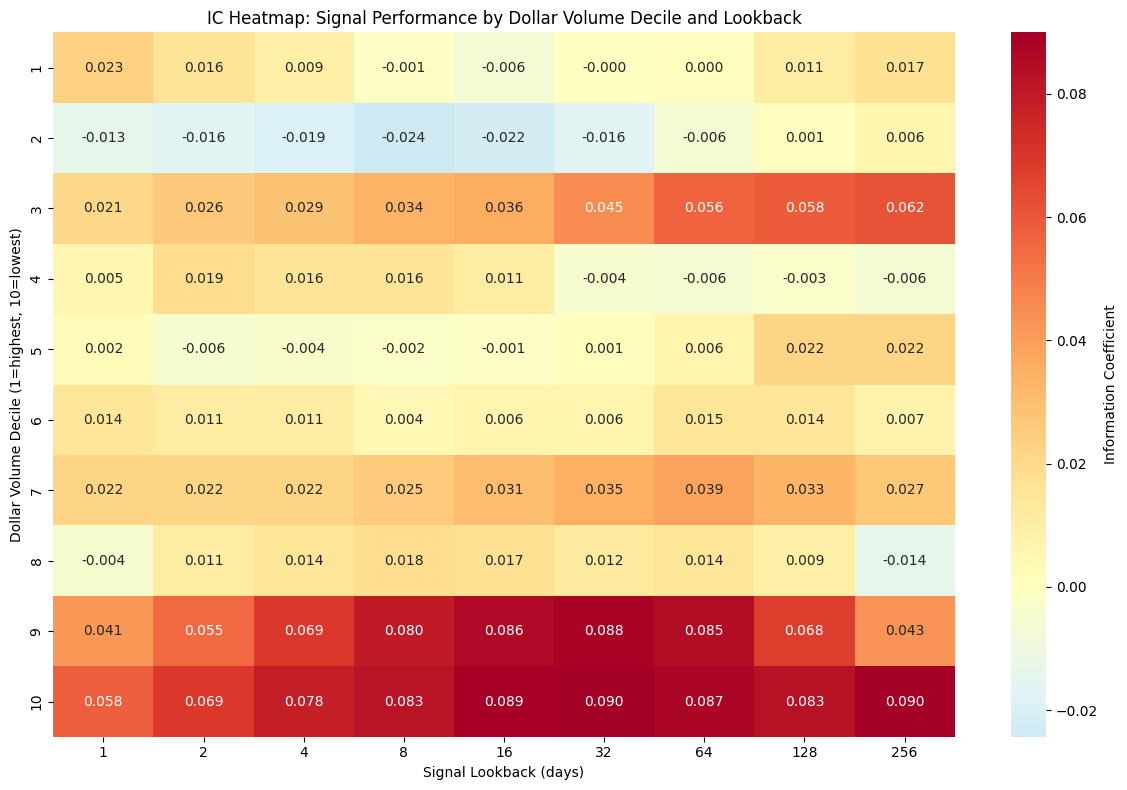


IC Summary by Decile:
dv_decile
1     0.007678
2    -0.012163
3     0.040858
4     0.005151
5     0.004465
6     0.009742
7     0.028571
8     0.008682
9     0.068275
10    0.080609
dtype: float64

IC Summary by Lookback:
lookback
1      0.016950
2      0.020757
4      0.022419
8      0.023259
16     0.024615
32     0.025618
64     0.029069
128    0.029545
256    0.025448
dtype: float64


In [136]:
# IC heatmap by dv_decile/lookback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize results matrix
ic_heatmap_data = []

for l in lookbacks:
    print(f"Computing IC for lookback {l}")
    sig_col = f"signal_{l}d"
    ret_col = f"fwd_combined_return_10d_demeaned"  # Using fixed horizon like above
    
    # Compute IC by dv_decile for this lookback
    for decile in range(1, 11):  # dv_deciles 1-10
        decile_data = df_filtered[df_filtered['dv_decile'] == decile]
        
        if len(decile_data) > 10:  # Need minimum observations
            # Compute daily IC within this decile
            daily_ics = (
                decile_data
                .groupby("timestamp")[[sig_col, ret_col]]
                .apply(lambda g: g.iloc[:, 0].corr(g.iloc[:, 1], min_periods=2) if len(g) >= 2 else np.nan)
                .dropna()
            )
            
            if len(daily_ics) > 0:
                ic_mean = daily_ics.mean()
            else:
                ic_mean = np.nan
        else:
            ic_mean = np.nan
            
        ic_heatmap_data.append({
            'lookback': l,
            'dv_decile': decile,
            'IC': ic_mean
        })

# Convert to DataFrame and pivot for heatmap
ic_df = pd.DataFrame(ic_heatmap_data)
ic_pivot = ic_df.pivot(index='dv_decile', columns='lookback', values='IC')

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    ic_pivot,
    annot=True,
    fmt='.3f',
    cmap='RdYlBu_r',
    center=0,
    cbar_kws={'label': 'Information Coefficient'}
)
plt.title('IC Heatmap: Signal Performance by Dollar Volume Decile and Lookback')
plt.xlabel('Signal Lookback (days)')
plt.ylabel('Dollar Volume Decile (1=highest, 10=lowest)')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nIC Summary by Decile:")
print(ic_pivot.mean(axis=1).sort_index())
print("\nIC Summary by Lookback:")
print(ic_pivot.mean(axis=0))

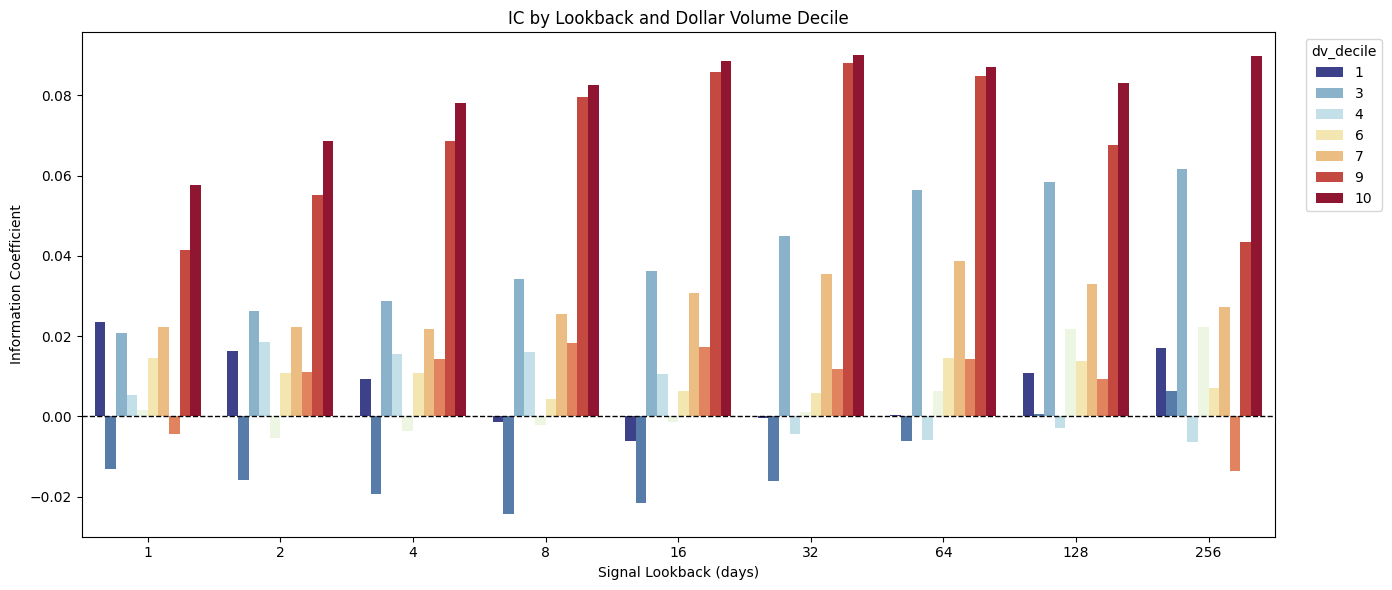

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the pivoted table for plotting
ic_long = ic_pivot.reset_index().melt(id_vars="dv_decile", var_name="lookback", value_name="IC")

plt.figure(figsize=(14, 6))
sns.barplot(
    data=ic_long,
    x="lookback",
    y="IC",
    hue="dv_decile",
    palette="RdYlBu_r"
)

plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.title("IC by Lookback and Dollar Volume Decile")
plt.xlabel("Signal Lookback (days)")
plt.ylabel("Information Coefficient")
plt.legend(title="dv_decile", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Signal Selection

In [138]:
df_filtered['signal'] = df_filtered['signal_128d']

Holding-period estimator ``H = 1/avg_turnover`` assumes ``GMV = 1``.

In [139]:
# find turnover for future plots
df_filtered['weight'] = df_filtered.groupby('timestamp')['signal'].transform(
		lambda x: (x - x.mean()) / (x - x.mean()).abs().sum()
)
W = df_filtered.pivot(values='weight', columns='symbol', index='timestamp')
avg_holding_period = 1/W.diff().abs().sum(axis=1).mean()
print(f"Avg holding period: {avg_holding_period:.2f}")

Avg holding period: 35.49


In [140]:
df_filtered

,symbol,timestamp,open,high,low,close,volume,mkt_cap,fundingRate,oi,...,fwd_combined_return_53d_demeaned,fwd_combined_return_54d_demeaned,fwd_combined_return_55d_demeaned,fwd_combined_return_56d_demeaned,fwd_combined_return_57d_demeaned,fwd_combined_return_58d_demeaned,fwd_combined_return_59d_demeaned,fwd_combined_return_60d_demeaned,signal,weight
13429,ADA,2021-01-02,0.17526,0.18516,0.16828,0.17759,7.812816e+08,4.601950e+09,0.000818,NaN,...,2.744772,3.145914,4.096737,4.415997,4.559126,4.151225,3.760788,3.564600,NaN,NaN
13430,ALGO,2021-01-02,0.39870,0.46340,0.38060,0.40800,2.352496e+08,1.056982e+08,0.000690,NaN,...,-0.575785,-0.519184,-0.539513,-0.301858,-0.338419,-0.491236,-0.478094,-0.388566,NaN,NaN
13432,ATOM,2021-01-02,5.87300,5.89500,5.18200,5.43000,8.370207e+06,1.030245e+09,0.002549,NaN,...,0.382333,0.316736,0.521958,0.505959,0.381694,0.256282,0.307669,0.638751,NaN,NaN
13435,BAL,2021-01-02,13.94900,14.99500,13.50100,14.72500,9.760985e+05,0.000000e+00,0.000300,NaN,...,-0.549302,-0.571135,-0.502106,-0.485247,-0.488815,-0.558139,-0.628804,-0.641135,NaN,NaN
13442,BTC,2021-01-02,29337.15000,33480.00000,28958.24000,32199.91000,5.455411e+05,5.965094e+11,0.002597,NaN,...,-1.630181,-1.468032,-1.486934,-1.562290,-1.445524,-1.630146,-1.633394,-1.718710,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263210,ZRO,2024-12-31,5.09410,5.27300,4.88410,4.99660,7.464610e+06,NaN,0.000300,2.093836e+07,...,-0.124786,-0.114317,-0.130391,-0.125514,-0.126539,-0.120592,-0.115145,-0.126104,NaN,NaN
263205,ZEC,2024-12-31,58.28000,59.81000,55.60000,56.25000,6.709596e+05,9.196884e+08,0.000300,1.836900e+07,...,-0.079250,-0.069695,-0.045922,-0.051512,-0.009514,-0.002769,0.013283,0.026194,-0.000084,0.002813
263204,YGG,2024-12-31,0.49300,0.51350,0.47400,0.48990,2.205967e+07,1.789715e+08,0.000300,6.237055e+06,...,-0.177087,-0.187965,-0.194266,-0.184142,-0.184650,-0.186145,-0.181118,-0.186850,-0.000270,0.001720
263203,YFI,2024-12-31,8262.00000,8417.00000,7906.00000,8001.00000,1.911383e+03,2.666471e+08,0.000300,8.088299e+06,...,0.047238,0.042932,0.060784,0.071426,0.047373,0.062250,0.042989,0.040844,-0.000166,0.002333


# Signal distribution

Five-number summary:
  Min     : -0.0107
  25th %ile: -0.0002
  Median  : -0.0001
  75th %ile: -0.0000
  Max     : 0.1411


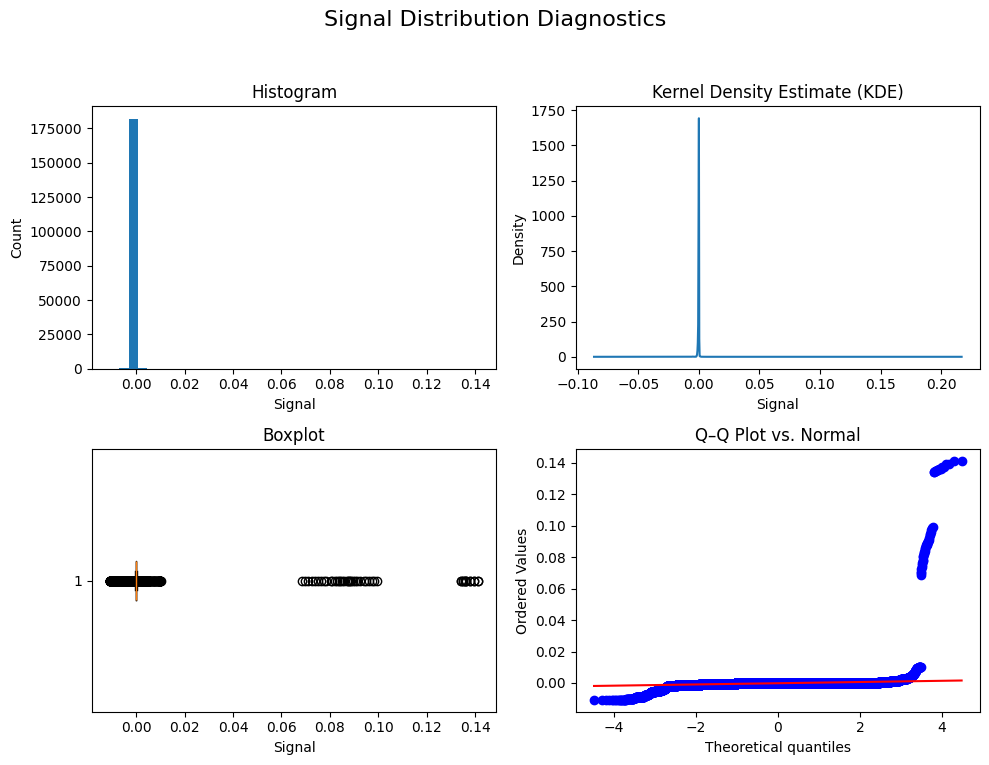

In [141]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

# extract and clean
signal = df_filtered['signal'].dropna()

# compute five-number summary
five_num = signal.quantile([0, .25, .5, .75, 1.0])
print("Five-number summary:")
print(f"  Min     : {five_num.loc[0.00]:.4f}")
print(f"  25th %ile: {five_num.loc[0.25]:.4f}")
print(f"  Median  : {five_num.loc[0.50]:.4f}")
print(f"  75th %ile: {five_num.loc[0.75]:.4f}")
print(f"  Max     : {five_num.loc[1.00]:.4f}")

# set up 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Signal Distribution Diagnostics', fontsize=16)

# 1. Histogram
axes[0, 0].hist(signal, bins=40)
axes[0, 0].set_title('Histogram')
axes[0, 0].set_xlabel('Signal')
axes[0, 0].set_ylabel('Count')

# 2. KDE
signal.plot.kde(ax=axes[0, 1])
axes[0, 1].set_title('Kernel Density Estimate (KDE)')
axes[0, 1].set_xlabel('Signal')

# 3. Boxplot
axes[1, 0].boxplot(signal, vert=False)
axes[1, 0].set_title('Boxplot')
axes[1, 0].set_xlabel('Signal')

# 4. Q–Q Plot
st.probplot(signal, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q–Q Plot vs. Normal')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Performance by ADV decile

Mean daily IC by dv_decile:
1.0     0.010802
2.0     0.000636
3.0     0.058461
4.0    -0.002868
5.0     0.021725
6.0     0.013662
7.0     0.033050
8.0     0.009296
9.0     0.067550
10.0    0.083140
dtype: float64


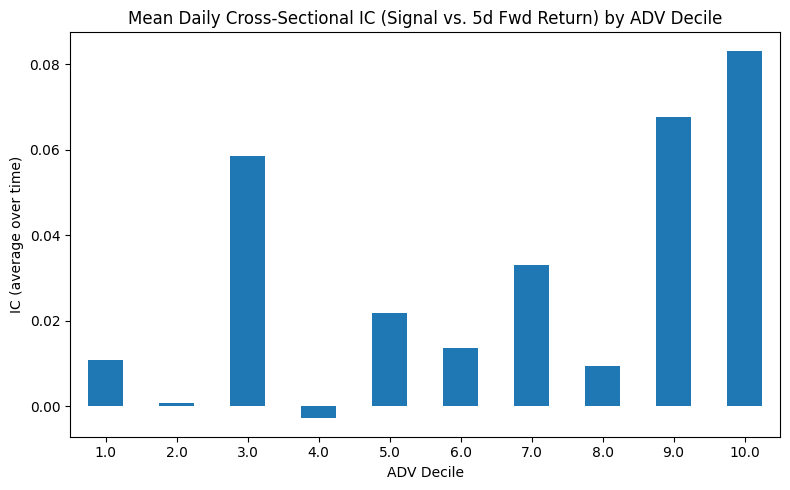

In [142]:
# Method 1: cross-sectional IC averaged over time, by dv_decile
import pandas as pd
import matplotlib.pyplot as plt

ic_by_decile = {}

for decile, g in df_filtered.groupby("dv_decile"):
    # For each day in this decile, compute cross-sectional correlation
    daily_ic = (
        g.groupby("timestamp")[["signal", "fwd_combined_return_10d_demeaned"]]
         .apply(lambda x: x["signal"].corr(x["fwd_combined_return_10d_demeaned"],
                                           min_periods=2) if len(x) >= 2 else None)
         .dropna()
    )
    if len(daily_ic) > 0:
        ic_by_decile[decile] = daily_ic.mean()
    else:
        ic_by_decile[decile] = float("nan")

# Convert to Series for plotting
ic_series = pd.Series(ic_by_decile).sort_index()

print("Mean daily IC by dv_decile:")
print(ic_series)

# Plot
ic_series.plot(kind='bar', figsize=(8, 5))
plt.title('Mean Daily Cross-Sectional IC (Signal vs. 5d Fwd Return) by ADV Decile')
plt.xlabel('ADV Decile')
plt.ylabel('IC (average over time)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Decay by decile

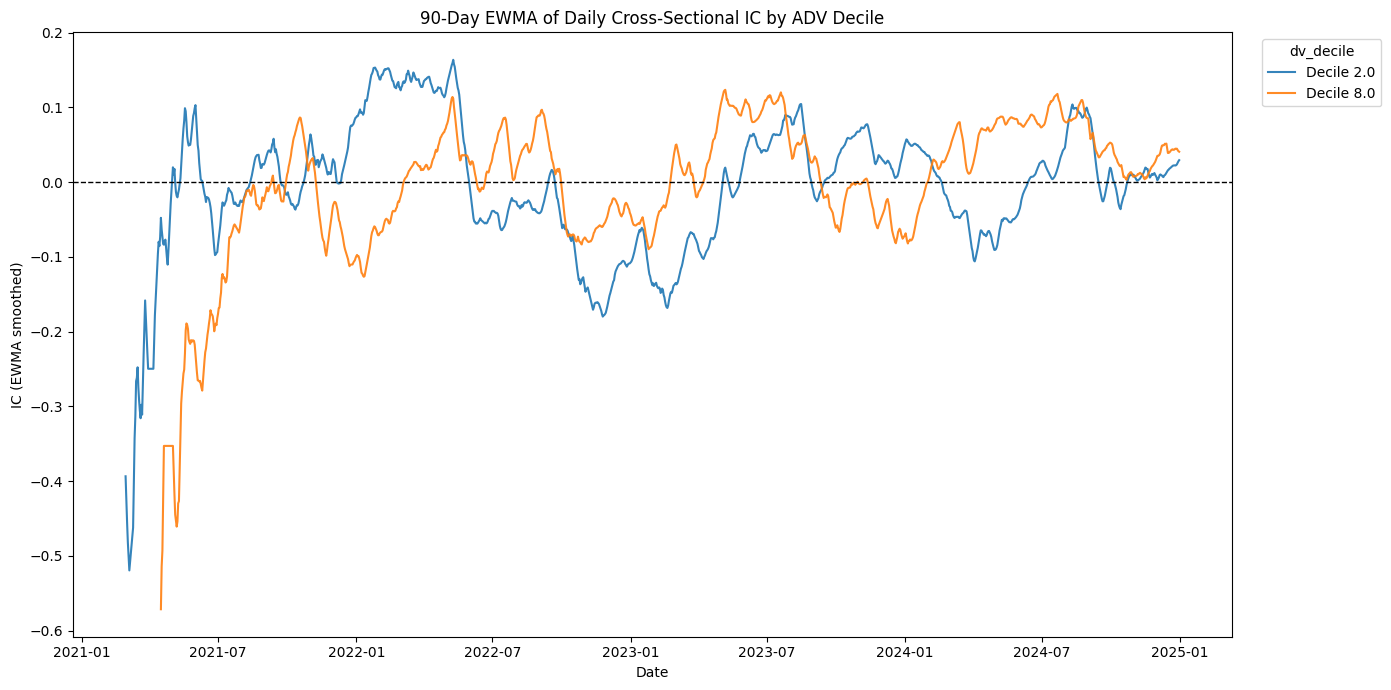

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

# Compute daily ICs per decile
ic_ts = (
    df_filtered
    .groupby(["dv_decile", "timestamp"])[["signal", "fwd_combined_return_10d_demeaned"]]
    .apply(lambda g: g["signal"].corr(g["fwd_combined_return_10d_demeaned"],
                                      min_periods=2) if len(g) >= 2 else None)
    .dropna()
    .reset_index(name="IC")
)

ic_ts = ic_ts[ic_ts.dv_decile.isin([2.0,8.0])]

# Pivot into deciles as columns, time as index
ic_matrix = ic_ts.pivot(index="timestamp", columns="dv_decile", values="IC").sort_index()

# Apply 90-day EWMA
ic_matrix_ewma = ic_matrix.ewm(span=180, min_periods=20).mean()

# Plot smoothed IC per decile
plt.figure(figsize=(14, 7))
for decile in ic_matrix_ewma.columns:
    plt.plot(ic_matrix_ewma.index, ic_matrix_ewma[decile], label=f"Decile {decile}", alpha=0.9)

plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.title("90-Day EWMA of Daily Cross-Sectional IC by ADV Decile")
plt.xlabel("Date")
plt.ylabel("IC (EWMA smoothed)")
plt.legend(title="dv_decile", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Regressions by adv decile

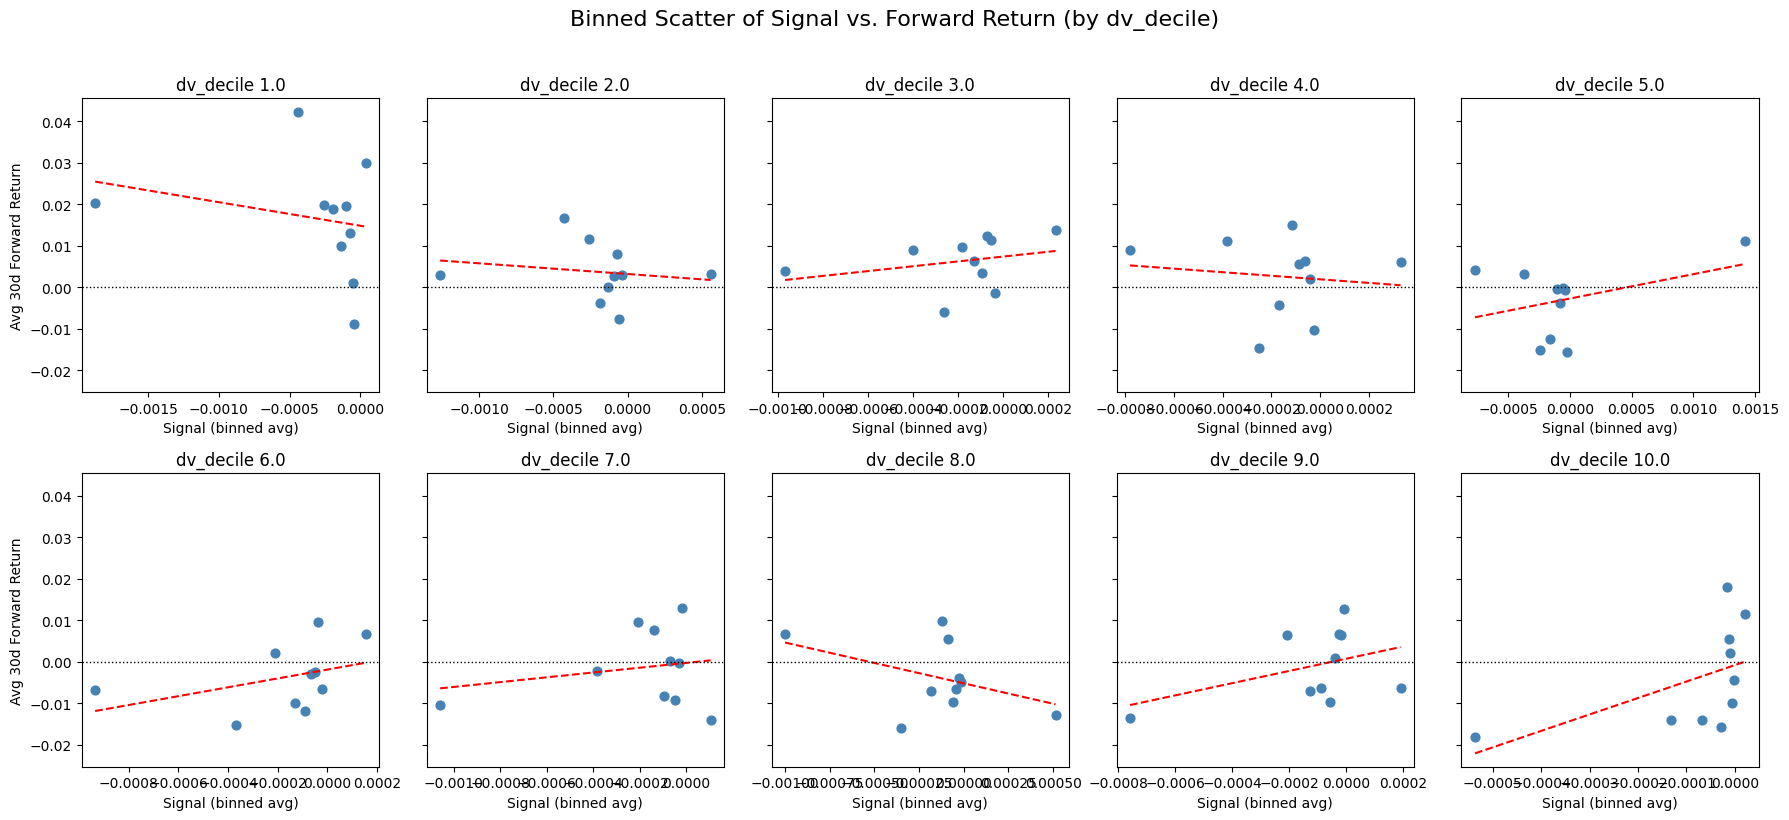

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

target = "fwd_combined_return_10d_demeaned"
signal_col = "signal"

# Set up subplots grid (2 rows x 5 cols = 10 panels)
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharey=True)
axes = axes.flatten()

for i, decile in enumerate(sorted(df_filtered['dv_decile'].unique())):
    ax = axes[i]
    g = df_filtered[df_filtered['dv_decile'] == decile][[signal_col, target]].dropna()

    if g.empty:
        ax.set_title(f"Decile {decile} (no data)")
        continue

    # Bin signal into 10 buckets
    g['signal_bin'] = pd.qcut(g[signal_col], 10, labels=False, duplicates="drop")

    # Compute mean return per bin
    bin_means = g.groupby('signal_bin')[[signal_col, target]].mean()

    # Scatter plot: binned signal vs avg fwd return
    ax.scatter(bin_means[signal_col], bin_means[target], s=40, color="steelblue")

    # Fit linear regression line through the 10 bins
    X = bin_means[[signal_col]].values
    y = bin_means[target].values
    if len(bin_means) > 1:
        reg = LinearRegression().fit(X, y)
        x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        y_line = reg.predict(x_line)
        ax.plot(x_line, y_line, color="red", linestyle="--")

    ax.axhline(0, color="black", linewidth=1, linestyle=":")
    ax.set_title(f"dv_decile {decile}")
    ax.set_xlabel("Signal (binned avg)")
    if i % 5 == 0:
        ax.set_ylabel("Avg 30d Forward Return")

plt.suptitle("Binned Scatter of Signal vs. Forward Return (by dv_decile)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# Regression fit

In [145]:
import statsmodels.api as sm
import numpy as np

# Choose which model to fit
use_interaction = True   # set False if you only want signal
target = 'fwd_combined_return_10d_demeaned'


if use_interaction:
    dataset = df_filtered[['signal', 'dv_decile', target]].dropna()

    # Create interaction term
    dataset['signal_x_dv_decile'] = dataset['signal'] * dataset['dv_decile']

    X = dataset[['signal', 'dv_decile', 'signal_x_dv_decile']]
    y = dataset[target]

    # Add constant
    X = sm.add_constant(X)

    # Fit model
    model = sm.OLS(y, X).fit()

    # Extract coefficients
    intercept        = model.params['const']
    coef_signal      = model.params['signal']
    coef_dv_decile   = model.params['dv_decile']
    coef_interaction = model.params['signal_x_dv_decile']

    # Forecast
    df_filtered['forecast'] = (
        intercept
        + coef_signal * df_filtered['signal']
        + coef_dv_decile * df_filtered['dv_decile']
        + coef_interaction * df_filtered['signal'] * df_filtered['dv_decile']
    )

else:
    dataset = df_filtered[['signal', target]].dropna()

    X = sm.add_constant(dataset[['signal']])
    y = dataset[target]

    model = sm.OLS(y, X).fit()

    # Extract coefficients
    intercept   = model.params['const']
    coef_signal = model.params['signal']

    # Forecast
    df_filtered['forecast'] = intercept + coef_signal * df_filtered['signal']

dataset = df_filtered[['dv_decile', target]].dropna()

print(model.summary())


                                   OLS Regression Results                                   
Dep. Variable:     fwd_combined_return_10d_demeaned   R-squared:                       0.001
Model:                                          OLS   Adj. R-squared:                  0.001
Method:                               Least Squares   F-statistic:                     51.11
Date:                              Wed, 24 Sep 2025   Prob (F-statistic):           5.20e-33
Time:                                      16:33:04   Log-Likelihood:                 88700.
No. Observations:                            175937   AIC:                        -1.774e+05
Df Residuals:                                175933   BIC:                        -1.774e+05
Df Model:                                         3                                         
Covariance Type:                          nonrobust                                         
                         coef    std err          t      P>|t|      [0

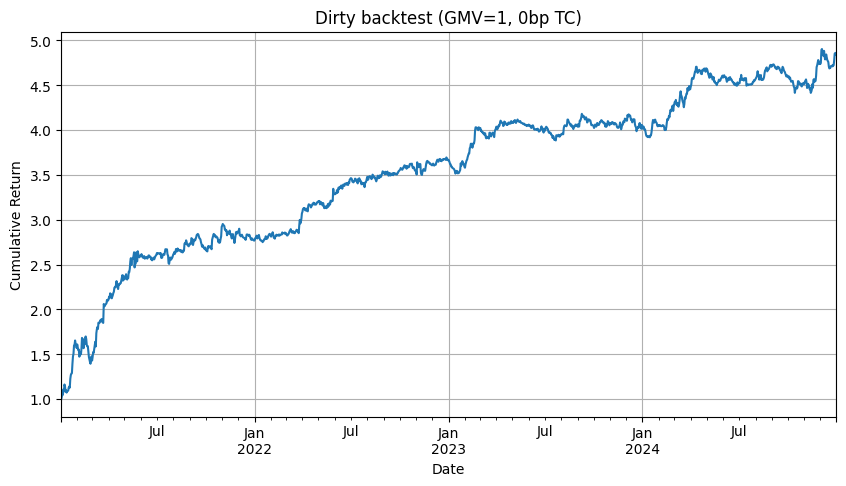

In [146]:
signals_wide = df_filtered.pivot(index='timestamp', columns='symbol', values='forecast')
df_filtered['return'] = df_filtered.groupby('symbol')['close'].pct_change()
returns_wide = df_filtered.pivot(index='timestamp', columns='symbol', values='return')

# generate stat-arb weights (demean + l1 norm)
W = signals_wide.sub(signals_wide.mean(axis=1), axis=0)
W = W.div(W.abs().sum(axis=1), axis=0)
W = W.fillna(0)

# compute daily PnL
pnl = (W.shift(1) * returns_wide).sum(axis=1)

# TC
turnover = (W.fillna(0) - W.shift(1).fillna(0)).abs().sum(axis=1)  # one-way traded notional
cost_bps = 0  # e.g., 1bp per one-way
pnl = pnl - (cost_bps/1e4) * turnover

# plot cumulative PnL
(pnl + 1).cumprod().plot(figsize=(10, 5))
plt.title(f"Dirty backtest (GMV=1, {cost_bps}bp TC)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

# Compare with interaction term and without


=== Variant 1: target ~ signal + dv_decile + signal*dv_decile ===
                                   OLS Regression Results                                   
Dep. Variable:     fwd_combined_return_10d_demeaned   R-squared:                       0.001
Model:                                          OLS   Adj. R-squared:                  0.001
Method:                               Least Squares   F-statistic:                     51.11
Date:                              Wed, 24 Sep 2025   Prob (F-statistic):           5.20e-33
Time:                                      16:34:04   Log-Likelihood:                 88700.
No. Observations:                            175937   AIC:                        -1.774e+05
Df Residuals:                                175933   BIC:                        -1.774e+05
Df Model:                                         3                                         
Covariance Type:                          nonrobust                                         
   

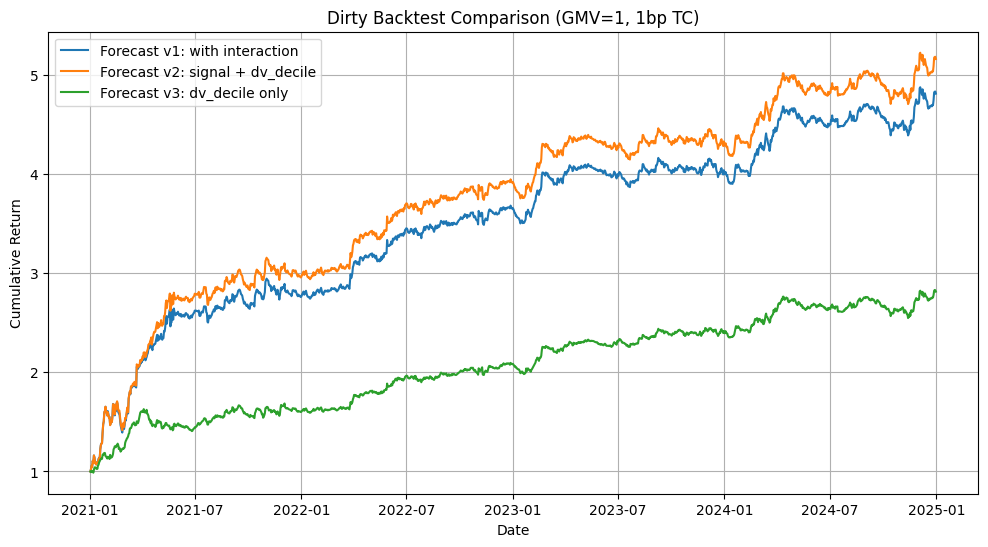

In [149]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

target = 'fwd_combined_return_10d_demeaned'

# -------------------------------
# Prepare dataset
# -------------------------------
dataset = df_filtered[['signal', 'dv_decile', target]].dropna()
y = dataset[target]

# -------------------------------
# Variant 1: with interaction
# -------------------------------
X1 = dataset.copy()
X1['signal_x_dv_decile'] = X1['signal'] * X1['dv_decile']
X1 = sm.add_constant(X1[['signal', 'dv_decile', 'signal_x_dv_decile']])
model1 = sm.OLS(y, X1).fit()

# -------------------------------
# Variant 2: signal + dv_decile
# -------------------------------
X2 = sm.add_constant(dataset[['signal', 'dv_decile']])
model2 = sm.OLS(y, X2).fit()

# -------------------------------
# Variant 3: dv_decile only
# -------------------------------
X3 = sm.add_constant(dataset[['dv_decile']])
model3 = sm.OLS(y, X3).fit()

# -------------------------------
# Print summaries
# -------------------------------
print("\n=== Variant 1: target ~ signal + dv_decile + signal*dv_decile ===")
print(model1.summary())

print("\n=== Variant 2: target ~ signal + dv_decile ===")
print(model2.summary())

print("\n=== Variant 3: target ~ dv_decile ===")
print(model3.summary())

# -------------------------------
# Add forecasts back to df_filtered
# -------------------------------
df_filtered['forecast_v1'] = model1.predict(sm.add_constant(
    df_filtered[['signal', 'dv_decile']].assign(
        signal_x_dv_decile = df_filtered['signal'] * df_filtered['dv_decile']
    )
))

df_filtered['forecast_v2'] = model2.predict(sm.add_constant(
    df_filtered[['signal', 'dv_decile']])
)

df_filtered['forecast_v3'] = model3.predict(sm.add_constant(
    df_filtered[['dv_decile']])
)

# -------------------------------
# Backtest function
# -------------------------------
def run_backtest(df, forecast_col, cost_bps=0):
    """
    Run simple stat-arb backtest given a forecast column name.
    GMV = 1, weights demeaned and L1-normalized.
    """
    signals_wide = df.pivot(index="timestamp", columns="symbol", values=forecast_col)
    returns_wide = df.pivot(index="timestamp", columns="symbol", values="return")

    # Weights: demean and normalize
    W = signals_wide.sub(signals_wide.mean(axis=1), axis=0)
    W = W.div(W.abs().sum(axis=1), axis=0).fillna(0)

    pnl = (W.shift(1) * returns_wide).sum(axis=1)

    # Transaction costs
    turnover = (W.fillna(0) - W.shift(1).fillna(0)).abs().sum(axis=1)
    pnl = pnl - (cost_bps / 1e4) * turnover

    return pnl

# Compute daily returns (ensure present)
df_filtered['return'] = df_filtered.groupby('symbol')['close'].pct_change()

# Run backtests
pnl_v1 = run_backtest(df_filtered, "forecast_v1", cost_bps=1)
pnl_v2 = run_backtest(df_filtered, "forecast_v2", cost_bps=1)
pnl_v3 = run_backtest(df_filtered, "forecast_v3", cost_bps=1)

# vol targeting
# target_vol = 0.10  # 10% annualized
# pnl_v1 = target_vol / (pnl_v1.std() * np.sqrt(365))
# pnl_v2 = target_vol / (pnl_v2.std() * np.sqrt(365))
# pnl_v3 = target_vol / (pnl_v3.std() * np.sqrt(365))

# Cumulative curves
cum_v1 = (1 + pnl_v1).cumprod()
cum_v2 = (1 + pnl_v2).cumprod()
cum_v3 = (1 + pnl_v3).cumprod()

# print sharpes
def sharpe(pnl):
    return pnl.mean() / pnl.std() * np.sqrt(365)
print(f"Sharpe v1: {sharpe(pnl_v1):.2f}")
print(f"Sharpe v2: {sharpe(pnl_v2):.2f}")
print(f"Sharpe v3: {sharpe(pnl_v3):.2f}")

plt.figure(figsize=(12, 6))
plt.plot(cum_v1, label="Forecast v1: with interaction")
plt.plot(cum_v2, label="Forecast v2: signal + dv_decile")
plt.plot(cum_v3, label="Forecast v3: dv_decile only")
plt.title("Dirty Backtest Comparison (GMV=1, 1bp TC)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()


<Axes: title={'center': 'Additive model outperformance'}, xlabel='timestamp'>

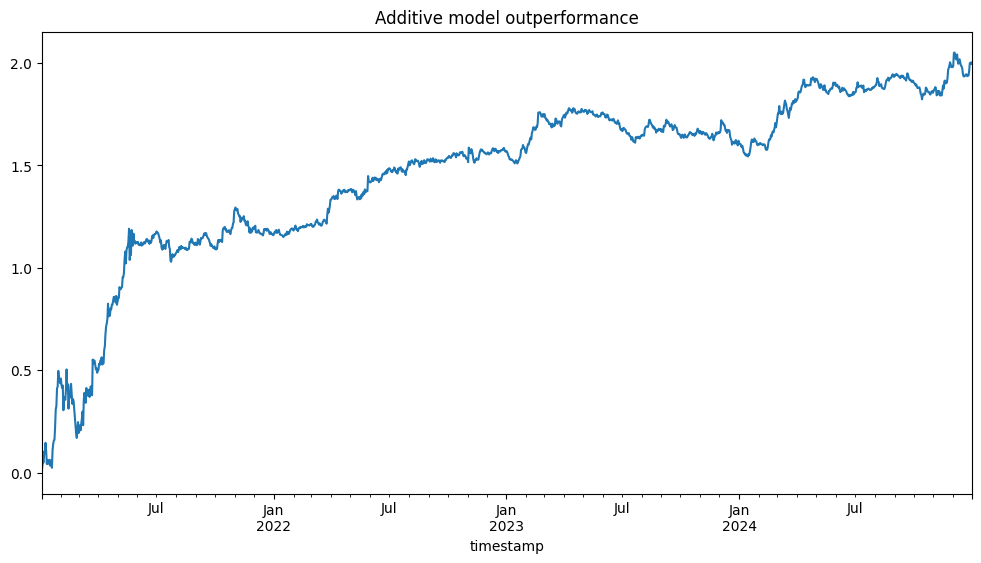

In [150]:
(cum_v1-cum_v3).plot(title="Additive model outperformance", figsize=(12,6))

In [ ]:
X.corr()

,const,signal,dv_decile,signal_x_dv_decile
const,NaN,NaN,NaN,NaN
signal,NaN,1.000000,0.027815,0.900570
dv_decile,NaN,0.027815,1.000000,-0.025651
signal_x_dv_decile,NaN,0.900570,-0.025651,1.000000


# Top 3 deciles only

[Top 3 ADV deciles only]
Sharpe v1: 2.26
Sharpe v2: 2.33
Sharpe v3: 3.82


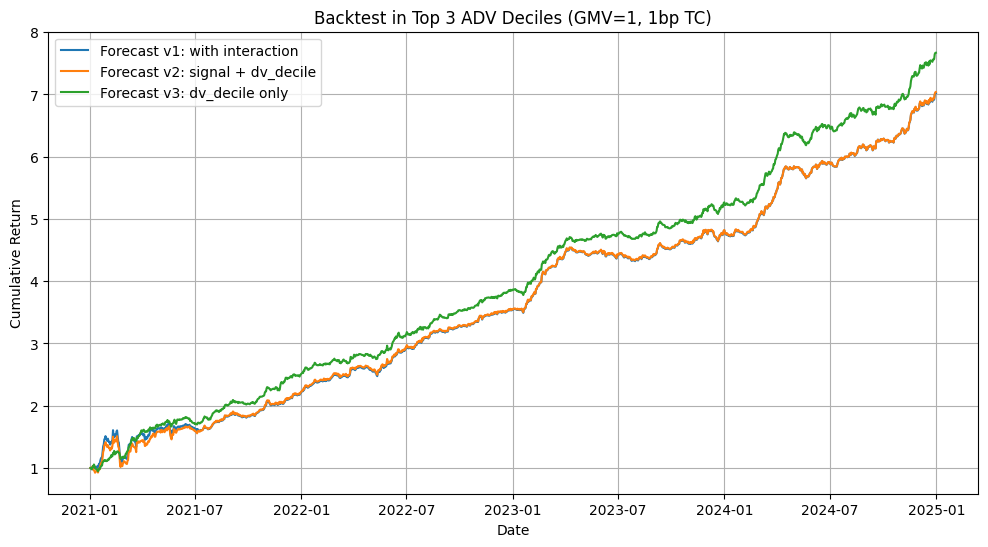

In [ ]:
# -------------------------------
# Restrict to top 3 deciles by ADV
# -------------------------------

# Filter df_filtered down to top 3 ADV deciles
df_liquid = df_filtered[df_filtered['dv_decile'] >= 5].copy()

# Recompute daily returns (to be safe)
df_liquid['return'] = df_liquid.groupby('symbol')['close'].pct_change()

# Run backtests on this subset
pnl_v1_liquid = run_backtest(df_liquid, "forecast_v1", cost_bps=1)
pnl_v2_liquid = run_backtest(df_liquid, "forecast_v2", cost_bps=1)
pnl_v3_liquid = run_backtest(df_liquid, "forecast_v3", cost_bps=1)

# Cumulative curves
cum_v1_liquid = (1 + pnl_v1_liquid).cumprod()
cum_v2_liquid = (1 + pnl_v2_liquid).cumprod()
cum_v3_liquid = (1 + pnl_v3_liquid).cumprod()

# Print sharpes
print(f"[Top 3 ADV deciles only]")
print(f"Sharpe v1: {sharpe(pnl_v1_liquid):.2f}")
print(f"Sharpe v2: {sharpe(pnl_v2_liquid):.2f}")
print(f"Sharpe v3: {sharpe(pnl_v3_liquid):.2f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(cum_v1_liquid, label="Forecast v1: with interaction")
plt.plot(cum_v2_liquid, label="Forecast v2: signal + dv_decile")
plt.plot(cum_v3_liquid, label="Forecast v3: dv_decile only")
plt.title("Backtest in Top 3 ADV Deciles (GMV=1, 1bp TC)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()
